# Méthodes statistiques pour la segmentation d'images

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, pi,exp
from random import random
def lit_image(nom_image):
    im=Image.open(nom_image)
    return (np.array(im),im.size[0],im.size[1])
def affiche_image(mat_image,titre,show=True):
    plt.title(titre)
    plt.imshow(mat_image,cmap='Greys_r')
    if show:
        plt.show()
def identif_classes(X):
    hist=np.histogram(X.flatten(),bins=2)
    return(hist[1][0],hist[1][2])
def bruit_gauss(X,m,n,cl1,cl2,m1,sig1,m2,sig2):
    gauss_1=np.random.normal(m1,sig1,(m,n))
    gauss_2=np.random.normal(m2,sig2,(m,n))
    return(np.where(X==cl1,gauss_1,gauss_2))
def norm_pdf(Y,mu,sig):
    return(np.exp((-(Y-mu)**2)/(2*sig**2))/(sqrt(2*pi)*sig))

### C'est un début


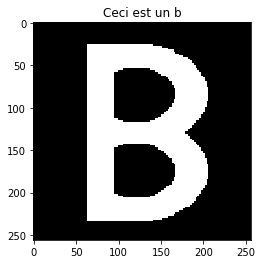

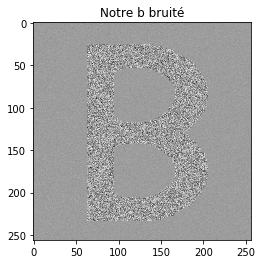

In [2]:
image,m,n=lit_image('./images/beee2.bmp')
affiche_image(image,'Ceci est un b',True)
cl1,cl2=identif_classes(image)
image_bruit=bruit_gauss(image,m,n,0,255,1,1,1,9)
affiche_image(image_bruit,'Notre b bruité',True)

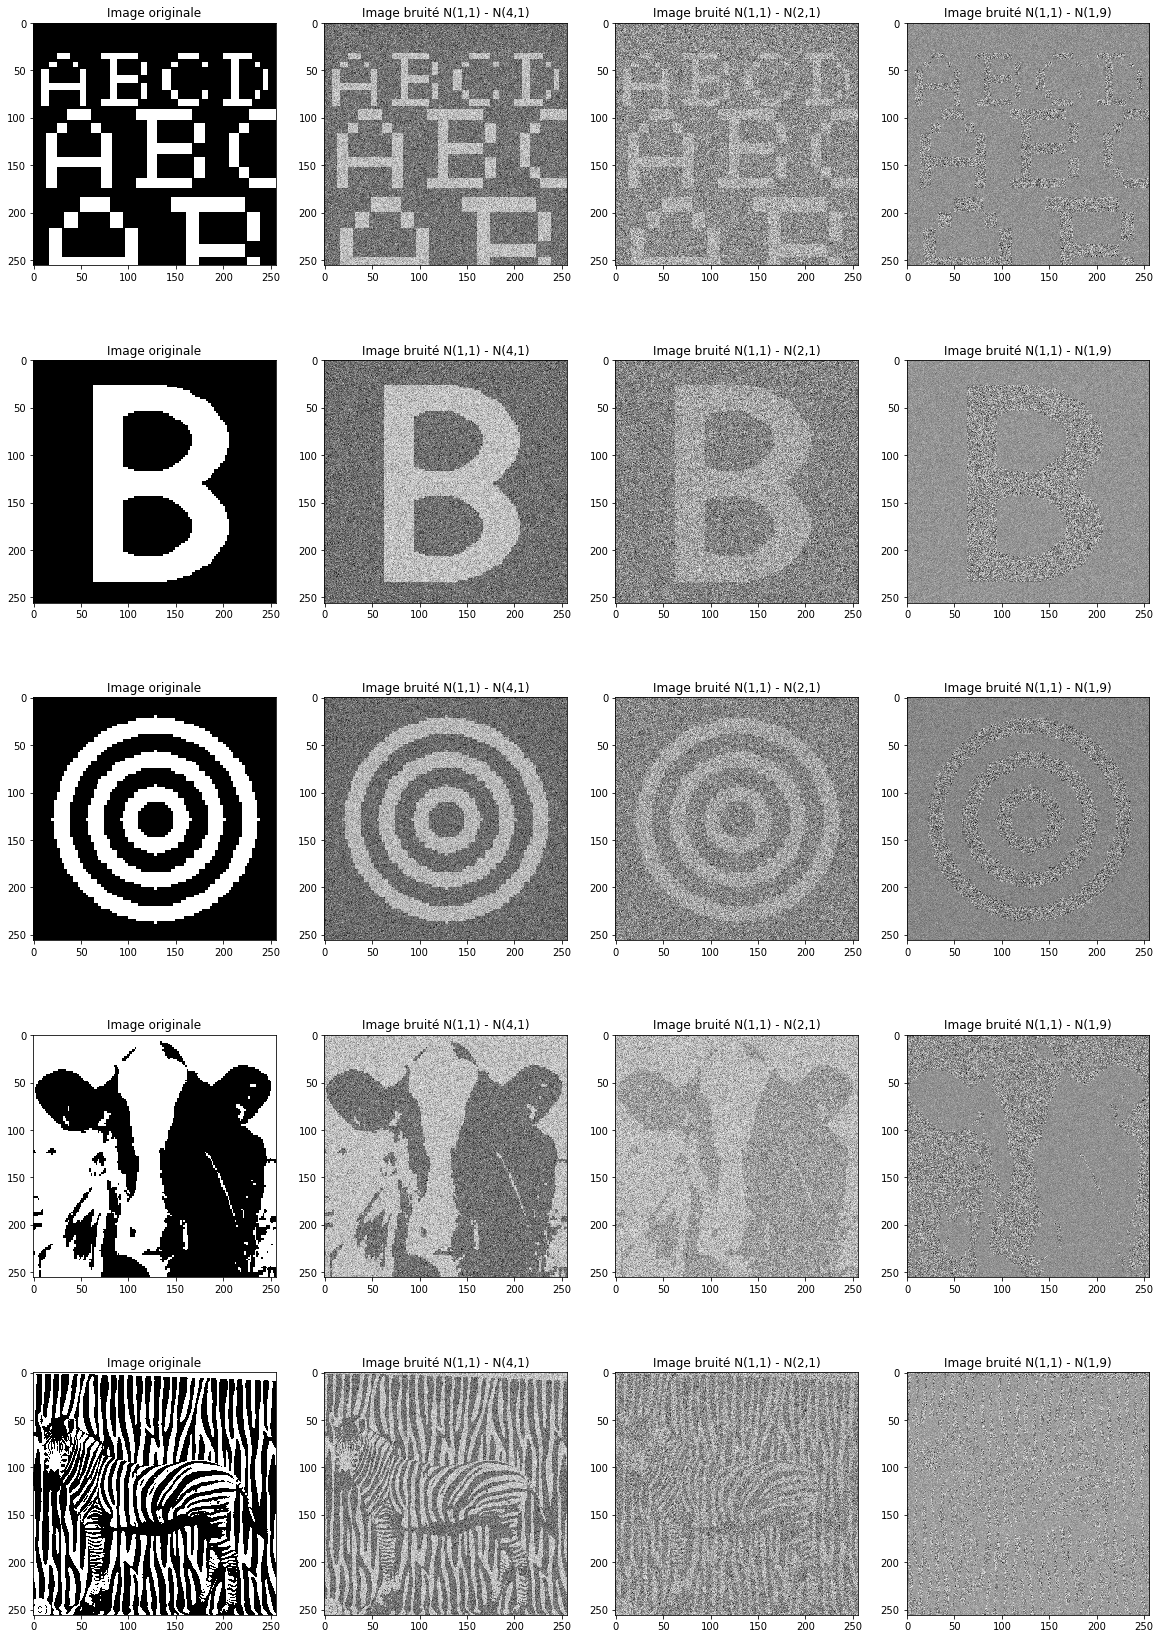

In [3]:
fig=plt.figure(figsize=(20,30))
images_listes=['alfa2.bmp','beee2.bmp','cible2.bmp','veau2.bmp','zebre2.bmp']
bruit_liste=[(4,1),(2,1),(1,9)]
for i,image in enumerate(images_listes):
    image,m,n=lit_image('./images/'+image)
    fig.add_subplot(5,4,i*4+1)
    affiche_image(image,'Image originale',False)
    for j,bruit in enumerate(bruit_liste):
        fig.add_subplot(5,4,i*4+j+2)
        image_bruite=bruit_gauss(image,m,n,0,255,1,1,bruit[0],sqrt(bruit[1]))
        affiche_image(image_bruite,'Image bruité N(1,1) - N('+str(bruit[0])+','+str(bruit[1])+')',False)
plt.show()


## Puisqu'il s'agit de segmenter, segmentons

In [2]:
from sklearn.cluster import KMeans
def Kmeans_images(B,classes,iter_KM):
    m,n=B.shape
    nb_classes=len(classes)
    cl1,cl2=classes
    kmeans=KMeans(n_clusters=nb_classes,init='random',max_iter=iter_KM).fit(B.reshape((-1,1)))
    values,labels=kmeans.cluster_centers_.squeeze(),kmeans.labels_
    min_values=min(values)
    image_segmentee=np.choose(labels,values).reshape((m,n))
    return np.where(image_segmentee==min_values, min(cl1,cl2), max(cl1,cl2))
def taux_erreur(A,B):
    moy=np.mean(np.abs(A-B)/255)
    return(min(moy,1-moy))

KeyboardInterrupt: 

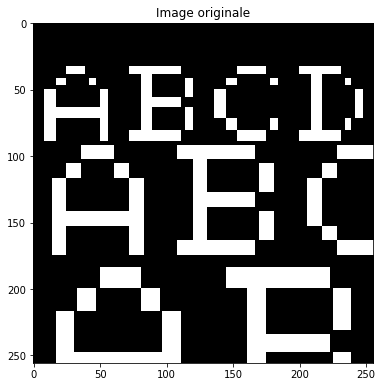

In [5]:
fig=plt.figure(figsize=(50,40))
images_listes=['alfa2.bmp','beee2.bmp','cible2.bmp','veau2.bmp','zebre2.bmp']
bruit_liste=[(4,1),(2,1),(1,9)]
Iter_KM=20

for i,image in enumerate(images_listes):
    image,m,n=lit_image('./images/'+image)
    fig.add_subplot(5,7,i*7+1)
    affiche_image(image,'Image originale',False)
    cl1,cl2=identif_classes(image)
    for j,bruit in enumerate(bruit_liste):
        m1,sig1,m2,sig2=1,1,bruit[0],sqrt(bruit[1])
        iterations=100
        taux_liste=np.zeros(iterations)
        for k in range(iterations):
            image_bruite=bruit_gauss(image,m,n,cl1,cl2,m1,sig1,m2,sig2)
            image_segmentee=Kmeans_images(image_bruite,[cl1,cl2],Iter_KM)
            taux_liste[k]=taux_erreur(image,image_segmentee)
        taux_moyen=np.mean(taux_liste)
        fig.add_subplot(5,7,i*7+j*2+2)
        affiche_image(image_bruite,'Image bruité N(1,1) - N('+str(m2)+','+str(sig2**2)+')',False)
        fig.add_subplot(5,7,i*7+j*2+3)
        affiche_image(image_segmentee,'Image segmentee par Kmeans Taux d\'erreur = ' +str(round(taux_moyen,2)),False)
plt.show()

In [3]:
import scipy.stats as stats
def calc_probaprio2(X,cl1,cl2):
    X=X.flatten()
    c1=len(X[X==cl1])
    c2=len(X[X==cl2])
    n=c1+c2
    p1=c1/n
    p2=c2/n
    return(p1,p2)
def MPM_Gauss(Y,cl1,cl2,p1,p2,m1,sig1,m2,sig2):
    return np.where(p1*norm_pdf(Y,m1,sig1)>p2*norm_pdf(Y,m2,sig2),cl1,cl2)

In [ ]:
fig=plt.figure(figsize=(50,40))
images_listes=['alfa2.bmp','beee2.bmp','cible2.bmp','veau2.bmp','zebre2.bmp']
bruit_liste=[(4,1),(2,1),(1,9)]

for i,image in enumerate(images_listes):
    image,m,n=lit_image('./images/'+image)
    fig.add_subplot(5,7,i*7+1)
    affiche_image(image,'Image originale',False)
    cl1,cl2=identif_classes(image)
    p1,p2=calc_probaprio2(image,0,255)
    for j,bruit in enumerate(bruit_liste):
        m1,sig1,m2,sig2=1,1,bruit[0],sqrt(bruit[1])
        iterations=200
        taux_liste=np.zeros(iterations)
        for k in range(iterations):
            image_bruite=bruit_gauss(image,m,n,cl1,cl2,m1,sig1,m2,sig2)
            image_segmentee=MPM_Gauss(image_bruite,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
            taux_liste[k]=taux_erreur(image,image_segmentee)
        taux_moyen=np.mean(taux_liste)
        fig.add_subplot(5,7,i*7+j*2+2)
        affiche_image(image_bruite,'Image bruité N(1,1) - N('+str(m2)+','+str(sig2**2)+')',False)
        fig.add_subplot(5,7,i*7+j*2+3)
        affiche_image(image_segmentee,'Image segmentee par MPM aveugle. Taux d\'erreur = ' +str(round(taux_moyen,2)),False)
plt.show()

## Segmentation non-supervisée

In [4]:
def calc_probapost_Gauss(Y,m,n,p1,p2,m1,sig1,m2,sig2):
    mat=np.array([p1*norm_pdf(Y,m1,sig1),p2*norm_pdf(Y,m2,sig2)])
    norm=mat[0]+mat[1]
    return(mat/norm)
def calc_EM(Y,m,n,p10,p20,m10,sig10,m20,sig20,nb_iterEM,returnList=False):
    p1,p2,m1,sig1,m2,sig2=p10,p20,m10,sig10,m20,sig20
    if returnList:
        p1list=[p1]
        p2list=[p2]
        m1list=[m1]
        sig1list=[sig1]
        m2list=[m2]
        sig2list=[sig2]
    for i in range(nb_iterEM):
        post1,post2=calc_probapost_Gauss(Y,m,n,p1,p2,m1,sig1,m2,sig2)
        p1=post1.mean()
        p2=post2.mean()
        m1=(post1*Y).sum()/post1.sum()
        m2=(post2*Y).sum()/post2.sum()
        sig1=np.sqrt(((post1*(Y-m1)**2).sum())/post1.sum())
        sig2=np.sqrt(((post2*(Y-m2)**2).sum())/post2.sum())
        if returnList:
            p1list+=[p1]
            p2list+=[p2]
            m1list+=[m1]
            sig1list+=[sig1]
            m2list+=[m2]
            sig2list+=[sig2]
    if not returnList:
        return(p1,p2,m1,sig1,m2,sig2)
    else:
        return(p1list,p2list,m1list,sig1list,m2list,sig2list)

### Segmentation par EM selon des écart au valeurs optimales

In [ ]:
image,m,n=lit_image('./images/beee2.bmp')
fig=plt.figure(figsize=(50,40))
bruit_liste=[(4,1),(2,1),(1,9)]
deviations=[(0.1,-0.1,0.5,0.5,0.5,0.5),(0.2,-0.2,5,1,5,1),(0.1,-0.1,1,3,1,3)]
cl1,cl2=identif_classes(image)
p1t,p2t=calc_probaprio2(image,0,255)

for i,deviation in enumerate(deviations):
    for j,bruit in enumerate(bruit_liste):
        m1t,sig1t,m2t,sig2t=1,1,bruit[0],sqrt(bruit[1])
        iterations=100
        taux_liste=np.zeros(iterations)
        for k in range(iterations):
            image_bruite=bruit_gauss(image,m,n,cl1,cl2,m1t,sig1t,m2t,sig2t)
            p1l,p2l,m1l,sig1l,m2l,sig2l=calc_EM(image_bruite,m,n,p1t+deviation[0],p2t+deviation[1],m1t+deviation[2],sig1t+deviation[3],m2t+deviation[4],sig2t+deviation[5],2000,True)
            image_segmentee=MPM_Gauss(image_bruite,cl1,cl2,p1l[-1],p2l[-1],m1l[-1],sig1l[-1],m2l[-1],sig2l[-1])
            taux_liste[k]=taux_erreur(image,image_segmentee)
        taux_moyen=np.mean(taux_liste)
        fig.add_subplot(3,3,i*3+j+1)
        plt.title('Configuration de déviation '+str(i+1)+' \n avec paramètres de bruits N(1,1) | N('+str(bruit[0])+','+str(bruit[1]**2)+') \n '+'Taux d\'erreur moyen de segmentation MPM = '+str(round(taux_moyen,2)))
        plt.xlabel('Nombre d\'itérations de EM')
        plt.plot(p1l, label='p1')
        plt.plot(p2l, label='p2')
        plt.plot(m1l, label='m1')
        plt.plot(m2l, label='m2')
        plt.plot(sig1l, label='sig1')
        plt.plot(sig2l, label='sig2')
        plt.legend(loc='best')
        plt.grid()
plt.show()


In [5]:
def est_empirique(X,Y,cl1,cl2):
    Xcl1=np.where(X==cl1,1,0)
    Xcl2=1-Xcl1
    p1=Xcl1.mean()
    p2=1-p1
    m1=(Y*Xcl1).sum()/(Xcl1.sum())
    m2=(Y*Xcl2).sum()/(Xcl2.sum())
    sig1=sqrt((Xcl1*(Y-m1)**2).sum()/(Xcl1.sum()))
    sig2=sqrt((Xcl2*(Y-m2)**2).sum()/(Xcl2.sum()))
    return(p1,p2,m1,sig1,m2,sig2)
def init_param(Y,cl1,cl2,iter_KM):
    X_KM=Kmeans_images(Y,[cl1,cl2],iter_KM)
    return(est_empirique(X_KM,Y,cl1,cl2)) 
def init_param_naive(Y,cl1,cl2):
    mean=Y.mean()
    std=Y.std()
    m1,m2=mean-std/2,mean+std/2
    sig1,sig2=std/2,std/2
    return(0.5,0.5,m1,sig1,m2,sig2)


## Segmentation EM par initialisation K-Means

In [ ]:
image,m,n=lit_image('./images/beee2.bmp')
fig=plt.figure(figsize=(30,10))
bruit_liste=[(4,1),(2,1),(1,9)]
cl1,cl2=identif_classes(image)
for j,bruit in enumerate(bruit_liste):
    iterations=100
    taux_liste=np.zeros(iterations)
    m1t,sig1t,m2t,sig2t=1,1,bruit[0],sqrt(bruit[1])
    for k in range(iterations):
        image_bruite=bruit_gauss(image,m,n,cl1,cl2,m1t,sig1t,m2t,sig2t)
        p10,p20,m10,sig10,m20,sig20=init_param(image_bruite,cl1,cl2,12)
        p1,p2,m1,sig1,m2,sig2=calc_EM(image_bruite,m,n,p10,p20,m10,sig10,m20,sig20,2000,True)
        image_segmentee=MPM_Gauss(image_bruite,cl1,cl2,p1[-1],p2[-1],m1[-1],sig1[-1],m2[-1],sig2[-1])
        taux_liste[k]=taux_erreur(image,image_segmentee)
    taux_moyen=np.mean(taux_liste)
    fig.add_subplot(1,3,j+1)
    plt.title('Segmentation par EM avec estimation des pm intiaux par Kmeans \n avec paramètres de bruits N(1,1) | N('+str(bruit[0])+','+str(bruit[1])+') \n '+'Taux d\'erreur moyen de segmentation MPM = '+str(round(taux_moyen,2)))
    plt.xlabel('Nombre d\'itérations de EM')
    plt.plot(p1, label='p1')
    plt.plot(p2, label='p2')
    plt.plot(m1, label='m1')
    plt.plot(m2, label='m2')
    plt.plot(sig1, label='sig1')
    plt.plot(sig2, label='sig2')
    plt.legend(loc='best')
    plt.grid()
plt.show()

### Segmentation EM par initialisation naive

In [ ]:
image,m,n=lit_image('./images/beee2.bmp')
fig=plt.figure(figsize=(30,10))
bruit_liste=[(4,1),(2,1),(1,9)]
cl1,cl2=identif_classes(image)
for j,bruit in enumerate(bruit_liste):
    iterations=100
    taux_liste=np.zeros(iterations)
    m1t,sig1t,m2t,sig2t=1,1,bruit[0],sqrt(bruit[1])
    for k in range(iterations):
        image_bruite=bruit_gauss(image,m,n,cl1,cl2,m1t,sig1t,m2t,sig2t)
        p10,p20,m10,sig10,m20,sig20=init_param_naive(image_bruite,cl1,cl2)
        p1,p2,m1,sig1,m2,sig2=calc_EM(image_bruite,m,n,p10,p20,m10,sig10,m20,sig20,2000,True)
        image_segmentee=MPM_Gauss(image_bruite,cl1,cl2,p1[-1],p2[-1],m1[-1],sig1[-1],m2[-1],sig2[-1])
        taux_liste[k]=taux_erreur(image,image_segmentee)
    taux_moyen=np.mean(taux_liste)
    fig.add_subplot(1,3,j+1)
    plt.title('Segmentation par EM avec estimation des pm intiaux naive \n avec paramètres de bruits N(1,1) | N('+str(bruit[0])+','+str(bruit[1])+') \n '+'Taux d\'erreur moyen de segmentation MPM = '+str(round(taux_moyen,2)))
    plt.xlabel('Nombre d\'itérations de EM')
    plt.plot(p1, label='p1')
    plt.plot(p2, label='p2')
    plt.plot(m1, label='m1')
    plt.plot(m2, label='m2')
    plt.plot(sig1, label='sig1')
    plt.plot(sig2, label='sig2')
    plt.legend(loc='best')
    plt.grid()
plt.show()

In [ ]:
fig=plt.figure(figsize=(50,40))
images_listes=['alfa2.bmp','beee2.bmp','cible2.bmp','veau2.bmp','zebre2.bmp']
bruit_liste=[(4,1),(2,1),(1,9)]

for i,image in enumerate(images_listes):
    image,m,n=lit_image('./images/'+image)
    fig.add_subplot(5,7,i*7+1)
    affiche_image(image,'Image originale',False)
    cl1,cl2=identif_classes(image)
    p1,p2=calc_probaprio2(image,0,255)
    for j,bruit in enumerate(bruit_liste):
        m1t,sig1t,m2t,sig2t=1,1,bruit[0],sqrt(bruit[1])
        iterations=100
        taux_liste=np.zeros(iterations)
        for k in range(iterations):
            image_bruite=bruit_gauss(image,m,n,cl1,cl2,m1t,sig1t,m2t,sig2t)
            p10,p20,m10,sig10,m20,sig20=init_param(image_bruite,cl1,cl2,20)
            p1,p2,m1,sig1,m2,sig2=calc_EM(image_bruite,m,n,p10,p20,m10,sig10,m20,sig20,2000,False)
            image_segmentee=MPM_Gauss(image_bruite,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
            taux_liste[k]=taux_erreur(image,image_segmentee)
        taux_moyen=np.mean(taux_liste)
        fig.add_subplot(5,7,i*7+j*2+2)
        affiche_image(image_bruite,'Image bruité N(1,1) - N('+str(m2t)+','+str(sig2t**2)+')',False)
        fig.add_subplot(5,7,i*7+j*2+3)
        affiche_image(image_segmentee,'Image segmentee par MPM aveugle. Taux d\'erreur = ' +str(round(taux_moyen,2)),False)
plt.show()

### Segmentation SEM aveugle

In [6]:
def tirage_apost(Ppost,cl1,cl2,m,n):
    rand_matrix=np.random.uniform(size=(m,n))
    return(np.where(rand_matrix<Ppost[0],cl1,cl2))
def calc_SEM(Y,m,n,cl1,cl2,p10,p20,m10,sig10,m20,sig20,nb_iterSEM,returnList=False):
    p1,p2,m1,sig1,m2,sig2=p10,p20,m10,sig10,m20,sig20
    if returnList:
        p1list=[p1]
        p2list=[p2]
        m1list=[m1]
        sig1list=[sig1]
        m2list=[m2]
        sig2list=[sig2]
    for i in range(nb_iterSEM):
        Ppost=calc_probapost_Gauss(Y,m,n,p1,p2,m1,sig1,m2,sig2)
        X_tirage=tirage_apost(Ppost,cl1,cl2,m,n)
        p1,p2,m1,sig1,m2,sig2=est_empirique(X_tirage,Y,cl1,cl2)
        if returnList:
            p1list+=[p1]
            p2list+=[p2]
            m1list+=[m1]
            sig1list+=[sig1]
            m2list+=[m2]
            sig2list+=[sig2]
    if not returnList:
        return(p1,p2,m1,sig1,m2,sig2)
    else:
        return(p1list,p2list,m1list,sig1list,m2list,sig2list)

In [ ]:
image,m,n=lit_image('./images/beee2.bmp')
fig=plt.figure(figsize=(30,10))
bruit_liste=[(4,1),(2,1),(1,9)]
cl1,cl2=identif_classes(image)
for j,bruit in enumerate(bruit_liste):
    iterations=100
    taux_liste=np.zeros(iterations)
    m1t,sig1t,m2t,sig2t=1,1,bruit[0],sqrt(bruit[1])
    for k in range(iterations):
        image_bruite=bruit_gauss(image,m,n,cl1,cl2,m1t,sig1t,m2t,sig2t)
        p10,p20,m10,sig10,m20,sig20=init_param(image_bruite,cl1,cl2,12)
        p1,p2,m1,sig1,m2,sig2=calc_SEM(image_bruite,m,n,cl1,cl2,p10,p20,m10,sig10,m20,sig20,2000,True)
        image_segmentee=MPM_Gauss(image_bruite,cl1,cl2,p1[-1],p2[-1],m1[-1],sig1[-1],m2[-1],sig2[-1])
        taux_liste[k]=taux_erreur(image,image_segmentee)
    taux_moyen=np.mean(taux_liste)
    fig.add_subplot(1,3,j+1)
    plt.title('Segmentation par SEM avec estimation des pm intiaux par Kmeans \n avec paramètres de bruits N(1,1) | N('+str(bruit[0])+','+str(bruit[1])+') \n '+'Taux d\'erreur moyen de segmentation MPM = '+str(round(taux_moyen,2)))
    plt.xlabel('Nombre d\'itérations de SEM')
    plt.plot(p1, label='p1')
    plt.plot(p2, label='p2')
    plt.plot(m1, label='m1')
    plt.plot(m2, label='m2')
    plt.plot(sig1, label='sig1')
    plt.plot(sig2, label='sig2')
    plt.legend(loc='best')
    plt.grid()
plt.show()

In [ ]:
fig=plt.figure(figsize=(50,40))
images_listes=['alfa2.bmp','beee2.bmp','cible2.bmp','veau2.bmp','zebre2.bmp']
bruit_liste=[(4,1),(2,1),(1,9)]

for i,image in enumerate(images_listes):
    image,m,n=lit_image('./images/'+image)
    fig.add_subplot(5,7,i*7+1)
    affiche_image(image,'Image originale',False)
    cl1,cl2=identif_classes(image)
    p1,p2=calc_probaprio2(image,0,255)
    for j,bruit in enumerate(bruit_liste):
        m1t,sig1t,m2t,sig2t=1,1,bruit[0],sqrt(bruit[1])
        iterations=100
        taux_liste=np.zeros(iterations)
        for k in range(iterations):
            image_bruite=bruit_gauss(image,m,n,cl1,cl2,m1t,sig1t,m2t,sig2t)
            p10,p20,m10,sig10,m20,sig20=init_param(image_bruite,cl1,cl2,12)
            p1,p2,m1,sig1,m2,sig2=calc_SEM(image_bruite,m,n,cl1,cl2,p10,p20,m10,sig10,m20,sig20,2000,False)
            image_segmentee=MPM_Gauss(image_bruite,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
            taux_liste[k]=taux_erreur(image,image_segmentee)
        taux_moyen=np.mean(taux_liste)
        fig.add_subplot(5,7,i*7+j*2+2)
        affiche_image(image_bruite,'Image bruité N(1,1) - N('+str(m2t)+','+str(sig2t**2)+')',False)
        fig.add_subplot(5,7,i*7+j*2+3)
        affiche_image(image_segmentee,'Image segmentee par MPM aveugle Taux d\'erreur = ' +str(round(taux_moyen,2)),False)
plt.show()

## Champs de Markov: Echantilloneur de Gibbs

In [7]:
def calc_proba_champs(alpha):
    probas=np.zeros((5,2))
    for i in range(1,6):
        probas[i-1][0]=(2*(i-1)-4)*alpha
        probas[i-1][1]=(2*(4-i+1)-4)*alpha
    probas=np.exp(probas)
    norm=probas.sum(axis=1)
    return((probas.T/norm).T)

In [8]:
def init_Gibbs(m,n,classe):
    random_mat=np.random.uniform(size=(m,n))
    X0=np.where(random_mat<0.5,classe[0],classe[1])
    return X0
def config_voisinage(I,m,n,classe,i,j):
    A=I[i-1:i+2,j-1:j+2]
    B=np.array([[0,1,0],[1,0,1],[0,1,0]])
    nb_vois_cl1=np.sum(B*[A==classe[0]])
    indice_klas= 0 if I[i][j]==classe[0] else 1
    return nb_vois_cl1,indice_klas
def tirage_classe(proba,classe):
    return (classe[0] if random()<proba else classe[1])
def iter_Gibbs_proba(I,m,n,classe,proba):
    X=I
    for i in range(1,m-1):
        for j in range(1,n-1):
            config,indice_klas=config_voisinage(X,m,n,classe,i,j)
            X[i][j]=tirage_classe(proba[config][0],classe)
    return(X)
def genere_Gibbs_proba(m,n,classe,proba,nb_iter):
    X=np.zeros((m,n,nb_iter+1))
    X[:,:,0]=init_Gibbs(m,n,classe)
    for i in range(nb_iter):
        X[:,:,i+1]=iter_Gibbs_proba(X[:,:,i],m,n,classe,proba)
    return(X[:,:,-1])
def redecoupe_image(Xtemp):
    return Xtemp[1:-1,1:-1]
def image_de_champs(alpha,m,n,classe,nb_iter,write=False):
    proba=calc_proba_champs(alpha)
    X=redecoupe_image(genere_Gibbs_proba(m,n,classe,proba,nb_iter))
    if(write):
        plt.imsave('./outfile.bmp', X,cmap='gray_r')
    return X

## Segmentation par MPM en champs cachés supervisée

In [9]:
def nouvelle_image(Y):
    m,n=Y.shape
    NewY=np.zeros((m+2,n+2))
    NewY[0][0]=Y[0][0]
    NewY[0][-1]=Y[0][-1]
    NewY[-1][0]=Y[-1][0]
    NewY[-1][-1]=Y[-1][-1]
    NewY[0][1:-1]=Y[0]
    NewY[-1][1:-1]=Y[-1]
    NewY[1:-1,0]=Y[:,0]
    NewY[1:-1,-1]=Y[:,-1]
    NewY[1:-1,1:-1]=Y
    return NewY
def calc_gibbs_proba_gauss(ys,m,n,m1,sig1,m2,sig2,classe,proba):
    Ptemp=proba*np.array([norm_pdf(ys,m1,sig1),norm_pdf(ys,m2,sig2)])
    Psum=Ptemp.sum()
    if(Psum!=0):
        return Ptemp/Psum
    else:
        return np.array([0.5,0.5])    
def iter_Gibbs_proba_apost_gauss(Y,I,m,n,m1,sig1,m2,sig2,classe,proba):
    X=I
    for i in range(1,m-1):
        for j in range(1,n-1):
            config,indice_klas=config_voisinage(X,m,n,classe,i,j)
            Ppost=calc_gibbs_proba_gauss(Y[i][j],m,n,m1,sig1,m2,sig2,classe,proba[config])
            X[i][j]=tirage_classe(Ppost[0],classe)
    return(X)       
def genere_Gibbs_proba_apost(Y,m,n,m1,sig1,m2,sig2,classe,proba,nb_iter):
    X=np.zeros((m,n,nb_iter+1))
    X[:,:,0]=init_Gibbs(m,n,classe)
    for i in range(nb_iter):
        X[:,:,i+1]=iter_Gibbs_proba_apost_gauss(Y,X[:,:,i],m,n,m1,sig1,m2,sig2,classe,proba)
    return(X[:,:,-1])
def choix_classe_MPM(X_simu,m,n,classe):
    m,n,nb_simu=X_simu.shape
    cl1,cl2=classe
    X_bool=np.where(X_simu==cl1,0,1)
    X_moy=X_simu.sum(axis=2)
    return np.where(X_moy<nb_simu/2,cl1,cl2)
def MPM_proba_gauss(Y,m,n,classe,m1,sig1,m2,sig2,proba,nb_iter,nb_simu):
    X_simu=np.zeros((m,n,nb_simu))
    for i in range(nb_simu):
        X_simu[:,:,i]=genere_Gibbs_proba_apost(Y,m,n,m1,sig1,m2,sig2,classe,proba,nb_iter)
    return(choix_classe_MPM(X_simu,m,n,classe))

def bruit_segmente_champs(image,m,n,classe,m1,sig1,m2,sig2,nb_iter_s,nb_simu_s,taux_liste,k):
    image_bruite=bruit_gauss(nouvelle_image(image),m,n,classe[0],classe[1],m1,sig1,m2,sig2)
    image_segmentee=MPM_proba_gauss(image_bruite,m,n,classe,m1,sig1,m2,sig2,proba,nb_iter_s,nb_simu_s)
    taux_liste[k]=taux_erreur(image,redecoupe_image(image_segmentee))
    return(image_bruite,image_segmentee)

In [ ]:
image,m,n=lit_image('./images/beee2_128.bmp')
image,m,n=image[:,:,0],128,128
image_agg=nouvelle_image(image)
image_bruite=bruit_gauss(image_agg,m+2,n+2,0,255,1,1,1,3)
proba=calc_proba_champs(1)
image_champs=MPM_proba_gauss(image_agg,m+2,n+2,[0,255],1,1,1,3,proba,30,3)
affiche_image(image_champs,'Taux d\'erreur de '+str(taux_erreur(image,redecoupe_image(image_champs))))

In [11]:
fig=plt.figure(figsize=(50,40))
bruit_liste=[(4,1),(2,1),(1,9)]
m,n=256,256
alpha=1
classe=[0,255]
nb_iter_g=10
nb_iter_s=30
nb_simu_s=3
proba=calc_proba_champs(alpha)
image=image_de_champs(alpha,m,n,classe,nb_iter_g)
for j,bruit in enumerate(bruit_liste):
    print(j)
    m1,sig1,m2,sig2=1,1,bruit[0],sqrt(bruit[1])
    iterations=1
    taux_liste=np.zeros(iterations)
    image_bruite,image_segmentee=bruit_segmente_champs(image,m,n,classe,m1,sig1,m2,sig2,nb_iter_s,nb_simu_s,taux_liste,0)
    for k in range(iterations):
        bruit_segmente_champs(image,m,n,classe,m1,sig1,m2,sig2,nb_iter_s,nb_simu_s,taux_liste,k)    
    taux_moyen=np.mean(taux_liste)
    fig.add_subplot(3,3,1+j*3)
    affiche_image(image,'Image générée',False)
    fig.add_subplot(3,3,2+j*3)
    affiche_image(image_bruite,'Image bruité N(1,1) - N('+str(m2)+','+str(sig2**2)+')',False)
    fig.add_subplot(3,3,3+j*3)
    affiche_image(image_segmentee,'Image segmentee par MPM Champs Taux d\'erreur = ' +str(round(taux_moyen,2)),False)
plt.show()

KeyboardInterrupt: 

<Figure size 3600x2880 with 0 Axes>

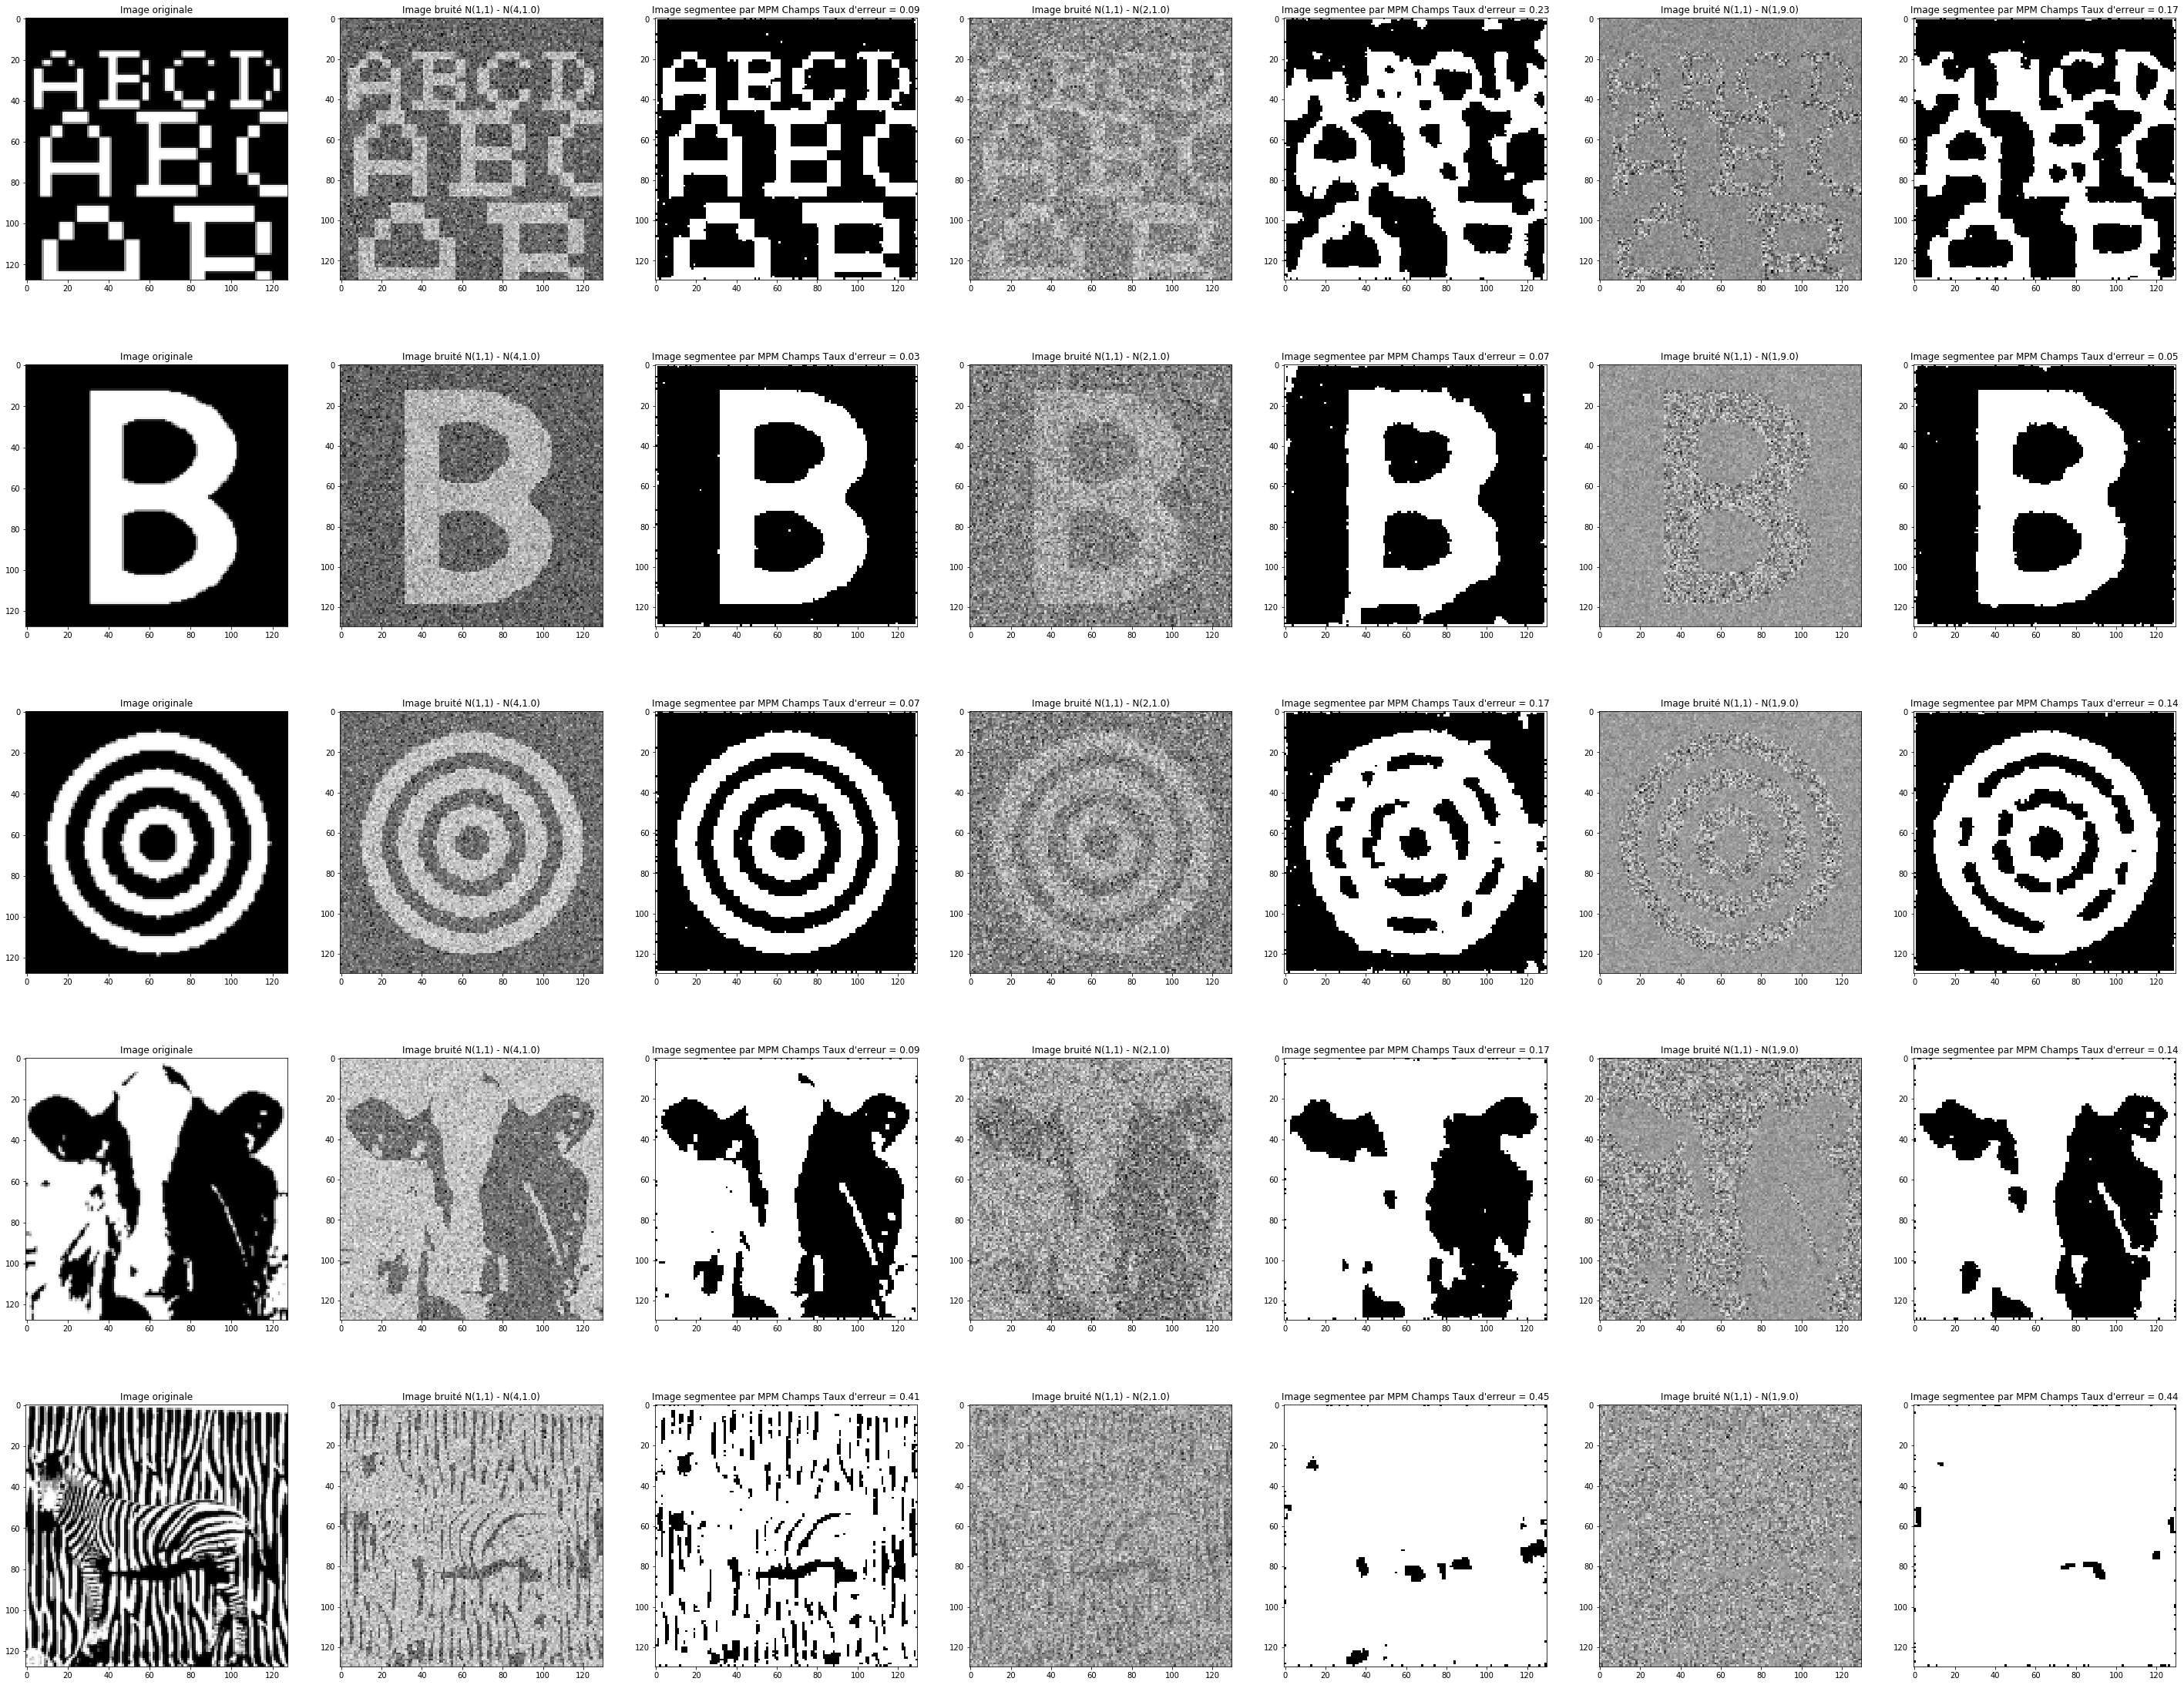

In [17]:
fig=plt.figure(figsize=(50,40))
images_listes=['alfa2_128.bmp','beee2_128.bmp','cible2_128.bmp','veau2_128.bmp','zebre2_128.bmp']
bruit_liste=[(4,1),(2,1),(1,9)]

alpha=1
classe=[0,255]
nb_iter_s=30
nb_simu_s=3
proba=calc_proba_champs(alpha)
for i,image in enumerate(images_listes):
    image,m,n=lit_image('./images/'+image)
    image,m,n=image[:,:,0],128,128
    fig.add_subplot(5,7,i*7+1)
    affiche_image(image,'Image originale',False)
    cl1,cl2=identif_classes(image)
    for j,bruit in enumerate(bruit_liste):
        m1,sig1,m2,sig2=1,1,bruit[0],sqrt(bruit[1])
        iterations=1
        taux_liste=np.zeros(iterations)
        image_bruite,image_segmentee=bruit_segmente_champs(image,m+2,n+2,classe,m1,sig1,m2,sig2,nb_iter_s,nb_simu_s,taux_liste,0)
        for k in range(iterations):
            bruit_segmente_champs(image,m+2,n+2,classe,m1,sig1,m2,sig2,nb_iter_s,nb_simu_s,taux_liste,k)    
        taux_moyen=np.mean(taux_liste)
        fig.add_subplot(5,7,i*7+2+j*2)
        affiche_image(image_bruite,'Image bruité N(1,1) - N('+str(m2)+','+str(sig2**2)+')',False)
        fig.add_subplot(5,7,i*7+3+j*2)
        affiche_image(image_segmentee,'Image segmentee par MPM Champs Taux d\'erreur = ' +str(round(taux_moyen,2)),False)
plt.show()

## Segmentation non supervisée par champs de Markov cachés

In [19]:
def est_empirique_EM(X,Y,cl1,cl2):
    Xcl1=np.where(X==cl1,1,0)
    Xcl2=1-Xcl1
    m1=(Y*Xcl1).sum()/(Xcl1.sum())
    m2=(Y*Xcl2).sum()/(Xcl2.sum())
    sig1=sqrt((Xcl1*(Y-m1)**2).sum()/(Xcl1.sum()))
    sig2=sqrt((Xcl2*(Y-m2)**2).sum()/(Xcl2.sum()))
    return(m1,sig1,m2,sig2)    
def init_param_EM(Y,cl1,cl2,m,n):
    X_KM=Kmeans_images(Y,[cl1,cl2],12)
    m1,sig1,m2,sig2=est_empirique_EM(X_KM,Y,cl1,cl2)
    return(calc_proba_champs(1),m1,sig1,m2,sig2)
def calc_N_part(X,m,n,cl1,cl2):
    N=np.zeros((5,2))
    for i in range(1,m-1):
        for j in range(1,n-1):
            config,indice_klas=config_voisinage(X,m,n,np.array([cl1,cl2]),i,j)
            N[config][indice_klas]+=1
    return(N)
def calc_N_post_part(X,m,n,classe):
    Npost_part=np.zeros((m,n,2))
    Npost_part[:,:,0]=np.where(X==classe[0],1,0)
    Npost_part[:,:,1]=np.where(X==classe[1],1,0)
    return Npost_part
def EM_gibbsien_Gauss(Y,m,n,cl1,cl2,m1,sig1,m2,sig2,proba,nb_iters_Gibbs_EM,nb_simu_EM):
    X_simu=np.zeros((m,n))
    N=np.zeros((5,2,nb_simu_EM))
    N_Post=np.zeros((m,n,2,nb_simu_EM))
    for simu in range(nb_simu_EM):
        X_simu=genere_Gibbs_proba_apost(Y,m,n,m1,sig1,m2,sig2,np.array([cl1,cl2]),proba,nb_iters_Gibbs_EM)
        N[:,:,simu]=calc_N_part(X_simu,m,n,cl1,cl2)
        N_Post[:,:,:,simu]=calc_N_post_part(X_simu,m,n,np.array([cl1,cl2]))
    Ppost=N_Post.mean(axis=3)
    proba=N.mean(axis=2)
    norm=proba.sum(axis=1)
    return((proba.T/norm).T,Ppost)
def estim_param_bruit_EM(Y,m,n,classe,Ppost):
    post1,post2=Ppost[:,:,0],Ppost[:,:,1]
    m1=(post1*Y).sum()/post1.sum()
    m2=(post2*Y).sum()/post2.sum()
    sig1=np.sqrt(((post1*(Y-m1)**2).sum())/post1.sum())
    sig2=np.sqrt(((post2*(Y-m2)**2).sum())/post2.sum())
    return m1,sig1,m2,sig2
def EM_gauss(Y,m,n,classe,nb_iter_EM,nb_iter_gibbs_EM,nb_simu_EM):
    cl1,cl2=classe
    proba,m1,sig1,m2,sig2=init_param_EM(Y,cl1,cl2,m,n)
    for i in range(nb_iter_EM):
        proba,Ppost=EM_gibbsien_Gauss(Y,m,n,cl1,cl2,m1,sig1,m2,sig2,proba,nb_iter_gibbs_EM,nb_simu_EM)
        m1,sig1,m2,sig2=estim_param_bruit_EM(Y,m,n,classe,Ppost)
    return(proba,m1,sig1,m2,sig2)
image,m,n=lit_image('./images/beee2.bmp')
image,m,n=np.array(Image.fromarray(image).resize((128,128))),128,128
image_agg=nouvelle_image(image)
image_bruite=bruit_gauss(image_agg,m+2,n+2,0,255,1,1,1,3)
proba,m1,sig1,m2,sig2=EM_gauss(image_bruite,m+2,n+2,[0,255],30,30,3)
print(proba)
image_champs=MPM_proba_gauss(image_agg,m+2,n+2,[0,255],m1,sig1,m2,sig2,proba,30,3)
affiche_image(image_champs,'Taux d\'erreur de '+str(taux_erreur(image,redecoupe_image(image_champs))))

KeyboardInterrupt: 

In [ ]:
from PIL import Image
fig=plt.figure(figsize=(50,40))
images_listes=['alfa2.bmp']#,'beee2.bmp','cible2.bmp','veau2.bmp','zebre2.bmp']
bruit_liste=[(4,1),(2,1),(1,9)]
for i,image in enumerate(images_listes):
    image,m,n=lit_image('./images/'+image)
    image,m,n=np.array(Image.fromarray(image).resize((128,128))),128,128
    fig.add_subplot(5,7,i*7+1) 
    affiche_image(image,'Image originale',False)
    cl1,cl2=identif_classes(image)
    image_agg=nouvelle_image(image)
    for j,bruit in enumerate(bruit_liste):
        m1t,sig1t,m2t,sig2t=1,1,bruit[0],sqrt(bruit[1])
        iterations=1
        taux_liste=np.zeros(iterations)
        print(i*3+j+1)
        for k in range(iterations):
            image_bruite=bruit_gauss(image_agg,m+2,n+2,0,255,m1t,sig1t,m2t,sig2t)
            probat,m1,sig1,m2,sig2=EM_gauss(image_bruite,m+2,n+2,[0,255],30,50,5)
            proba=calc_proba_champs(1)
            print(m1,sig1,m2,sig2)
            print(proba,probat)
            image_segmentee=MPM_proba_gauss(image_agg,m+2,n+2,[0,255],m1,sig1,m2,sig2,proba,30,3)
            taux_liste[k]=taux_erreur(image,redecoupe_image(image_segmentee))
        taux_moyen=np.mean(taux_liste)
        fig.add_subplot(5,7,i*7+j*2+2)
        affiche_image(image_bruite,'Image bruité N(1,1) - N('+str(m2t)+','+str(sig2t**2)+')',False)
        fig.add_subplot(5,7,i*7+j*2+3)
        affiche_image(image_segmentee,'Image segmentee par MPM champs Taux d\'erreur = ' +str(round(taux_moyen,2)),False)
plt.show()

1
0.9831076318519031 1.0218737738023214 3.6786488951579783 1.3274283444107116
[[3.3535013e-04 9.9966465e-01]
 [1.7986210e-02 9.8201379e-01]
 [5.0000000e-01 5.0000000e-01]
 [9.8201379e-01 1.7986210e-02]
 [9.9966465e-01 3.3535013e-04]] [[0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [3.79804560e-01 6.20195440e-01]
 [9.98642534e-01 1.35746606e-03]
 [9.99980807e-01 1.91927528e-05]]
2


Champs


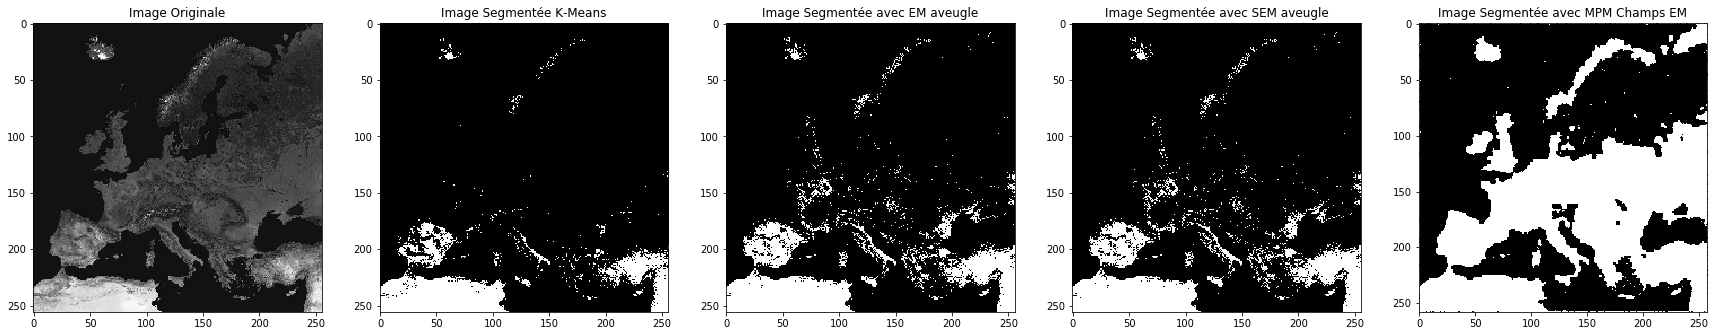

In [13]:
image=np.array(Image.open('./images/europe.jpg')).mean(axis=2)
image,m,n=np.array(Image.fromarray(image).resize((256,256))),256,256
cl1,cl2=0,255
fig=plt.figure(figsize=(30,10))
fig.add_subplot(1,5,1)
affiche_image(image,'Image Originale',False)
image_Kmeans=Kmeans_images(image,[cl1,cl2],12)
fig.add_subplot(1,5,2)
affiche_image(image_Kmeans,'Image Segmentée K-Means',False)
p10,p20,m10,sig10,m20,sig20=init_param(image,cl1,cl2,12)
p1,p2,m1,sig1,m2,sig2=calc_EM(image,m,n,p10,p20,m10,sig10,m20,sig20,2000,False)
image_EM_aveugle=MPM_Gauss(image,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
fig.add_subplot(1,5,3)
affiche_image(image_EM_aveugle,'Image Segmentée avec EM aveugle',False)
p1,p2,m1,sig1,m2,sig2=calc_SEM(image,m,n,cl1,cl2,p10,p20,m10,sig10,m20,sig20,2000,False)
image_SEM_aveugle=MPM_Gauss(image,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
fig.add_subplot(1,5,4)
affiche_image(image_SEM_aveugle,'Image Segmentée avec SEM aveugle',False)
print('Champs')
image_agg=nouvelle_image(image)
proba,m1,sig1,m2,sig2=EM_gauss(image_agg,m+2,n+2,[0,255],60,30,3)
image_MPM_champs=MPM_proba_gauss(image_agg,m+2,n+2,[0,255],m1,sig1,m2,sig2,proba,50,3)
fig.add_subplot(1,5,5)
affiche_image(image_MPM_champs,'Image Segmentée avec MPM Champs EM',False)
plt.show()

Champs


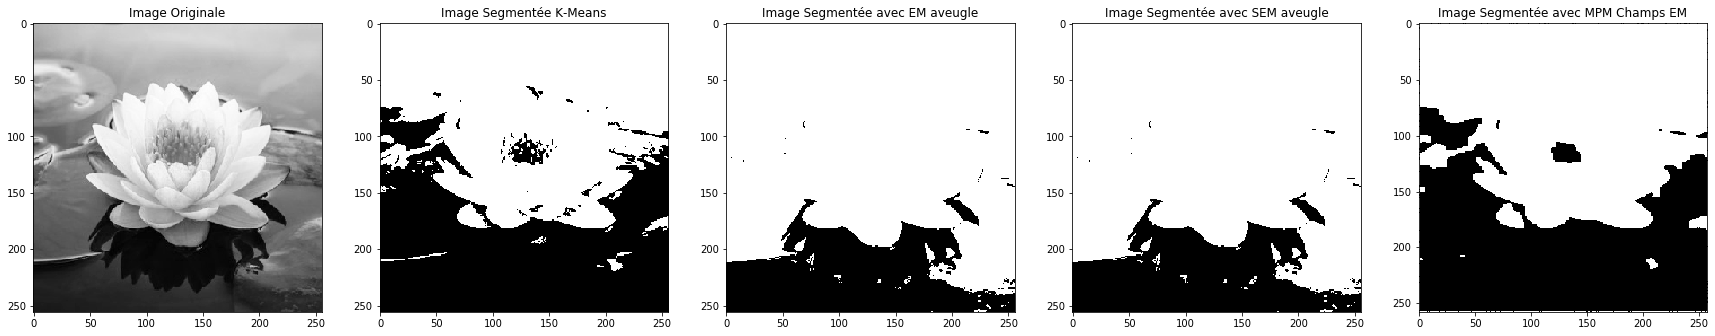

In [11]:
image=np.array(Image.open('./images/lotus.jpg')).mean(axis=2)
image,m,n=np.array(Image.fromarray(image).resize((256,256))),256,256
cl1,cl2=0,255
fig=plt.figure(figsize=(30,10))
fig.add_subplot(1,5,1)
affiche_image(image,'Image Originale',False)
image_Kmeans=Kmeans_images(image,[cl1,cl2],12)
fig.add_subplot(1,5,2)
affiche_image(image_Kmeans,'Image Segmentée K-Means',False)
p10,p20,m10,sig10,m20,sig20=init_param(image,cl1,cl2,12)
p1,p2,m1,sig1,m2,sig2=calc_EM(image,m,n,p10,p20,m10,sig10,m20,sig20,2000,False)
image_EM_aveugle=MPM_Gauss(image,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
fig.add_subplot(1,5,3)
affiche_image(image_EM_aveugle,'Image Segmentée avec EM aveugle',False)
p1,p2,m1,sig1,m2,sig2=calc_SEM(image,m,n,cl1,cl2,p10,p20,m10,sig10,m20,sig20,2000,False)
image_SEM_aveugle=MPM_Gauss(image,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
fig.add_subplot(1,5,4)
affiche_image(image_SEM_aveugle,'Image Segmentée avec SEM aveugle',False)
print('Champs')
image_agg=nouvelle_image(image)
proba,m1,sig1,m2,sig2=EM_gauss(image_agg,m+2,n+2,[0,255],60,30,3)
image_MPM_champs=MPM_proba_gauss(image_agg,m+2,n+2,[0,255],m1,sig1,m2,sig2,proba,50,3)
fig.add_subplot(1,5,5)
affiche_image(image_MPM_champs,'Image Segmentée avec MPM Champs EM',False)
plt.show()

Champs


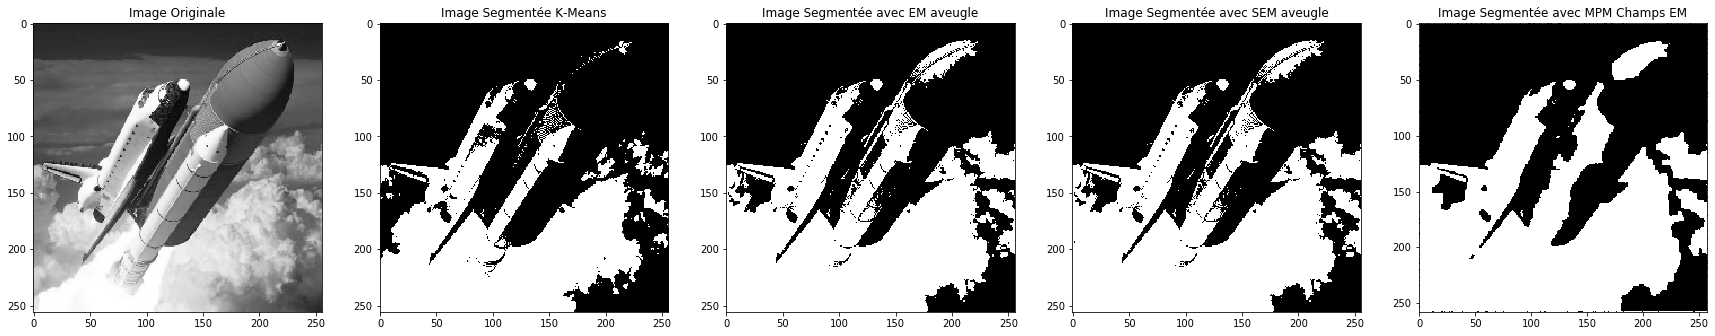

In [12]:
image=np.array(Image.open('./images/fusee.jpg')).mean(axis=2)
image,m,n=np.array(Image.fromarray(image).resize((256,256))),256,256
cl1,cl2=0,255
fig=plt.figure(figsize=(30,10))
fig.add_subplot(1,5,1)
affiche_image(image,'Image Originale',False)
image_Kmeans=Kmeans_images(image,[cl1,cl2],12)
fig.add_subplot(1,5,2)
affiche_image(image_Kmeans,'Image Segmentée K-Means',False)
p10,p20,m10,sig10,m20,sig20=init_param(image,cl1,cl2,12)
p1,p2,m1,sig1,m2,sig2=calc_EM(image,m,n,p10,p20,m10,sig10,m20,sig20,2000,False)
image_EM_aveugle=MPM_Gauss(image,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
fig.add_subplot(1,5,3)
affiche_image(image_EM_aveugle,'Image Segmentée avec EM aveugle',False)
p1,p2,m1,sig1,m2,sig2=calc_SEM(image,m,n,cl1,cl2,p10,p20,m10,sig10,m20,sig20,2000,False)
image_SEM_aveugle=MPM_Gauss(image,cl1,cl2,p1,p2,m1,sig1,m2,sig2)
fig.add_subplot(1,5,4)
affiche_image(image_SEM_aveugle,'Image Segmentée avec SEM aveugle',False)
print('Champs')
image_agg=nouvelle_image(image)
proba,m1,sig1,m2,sig2=EM_gauss(image_agg,m+2,n+2,[0,255],60,30,3)
image_MPM_champs=MPM_proba_gauss(image_agg,m+2,n+2,[0,255],m1,sig1,m2,sig2,proba,50,3)
fig.add_subplot(1,5,5)
affiche_image(image_MPM_champs,'Image Segmentée avec MPM Champs EM',False)
plt.show()